In [1]:
!nvidia-smi

Sun Mar 16 19:29:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   57C    P8             15W /  150W |     444MiB /  16384MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports and constants

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))
import os
import torch
from torchvision import transforms
import torchvision
from src import data_setup, engine, model_builder, utils


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "../inputs/pizza_steak_sushi/train"
test_dir = "../inputs/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
data_transform = weights.transforms()

# Train

In [8]:
data_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Epoch 1/5 | Train Loss: 1.0313, Train Acc: 0.5117 | Test Loss: 0.8690, Test Acc: 0.6723
Epoch 2/5 | Train Loss: 0.8754, Train Acc: 0.6914 | Test Loss: 0.7996, Test Acc: 0.7027
Epoch 3/5 | Train Loss: 0.7953, Train Acc: 0.6523 | Test Loss: 0.6978, Test Acc: 0.8248
Epoch 4/5 | Train Loss: 0.7233, Train Acc: 0.7656 | Test Loss: 0.5792, Test Acc: 0.9062
Epoch 5/5 | Train Loss: 0.6084, Train Acc: 0.8906 | Test Loss: 0.5739, Test Acc: 0.8759


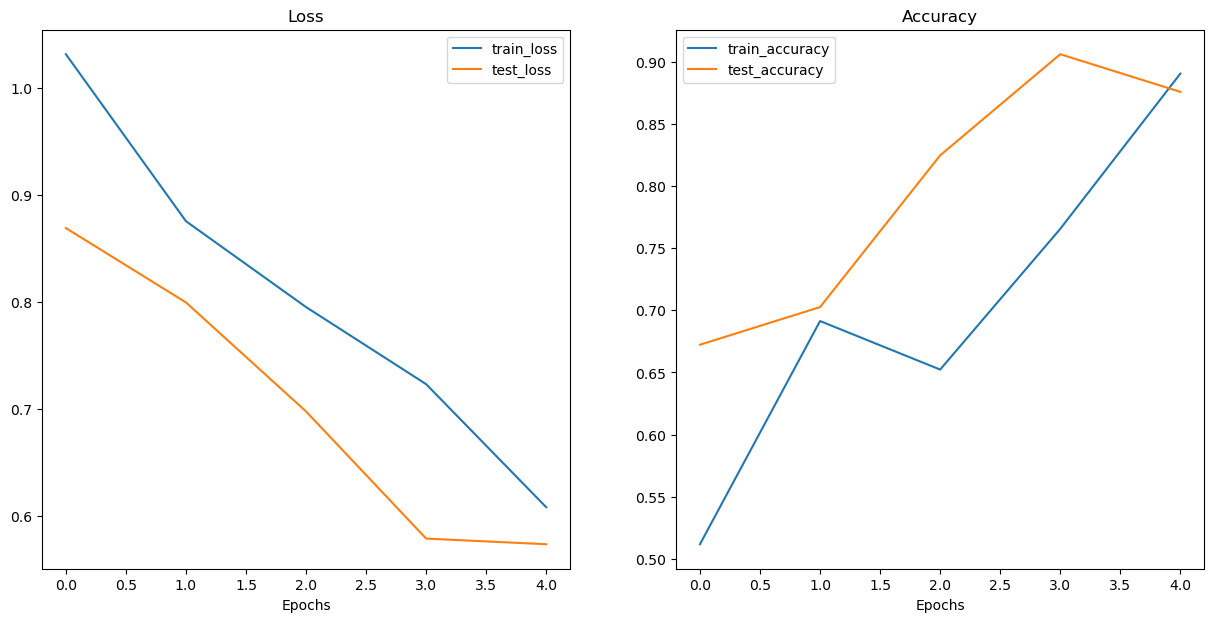

In [9]:
# Create DataLoaders with help from data_setup.py
torch.manual_seed(42)
torch.cuda.manual_seed(42)

dataloader = data_setup.CustomDataloader(train_dir=train_dir, test_dir=test_dir,
                                         transform=data_transform, batch_size=BATCH_SIZE, transform_test_data=True)
train_dataloader, test_dataloader = dataloader.get_dataloaders()
class_names = dataloader.classes

# dataloader, class_names

# Create model with help from model_builder.py
# model = model_builder.TinyVGG(
#     input_shape=3,
#     hidden_units=HIDDEN_UNITS,
#     output_shape=len(class_names)
# ).to(device)

# Freeze Feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Train Classifier
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
# # Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# # Start training with help from engine.py
results=engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device, log_interval=1)
engine.plot_loss_curves(results)

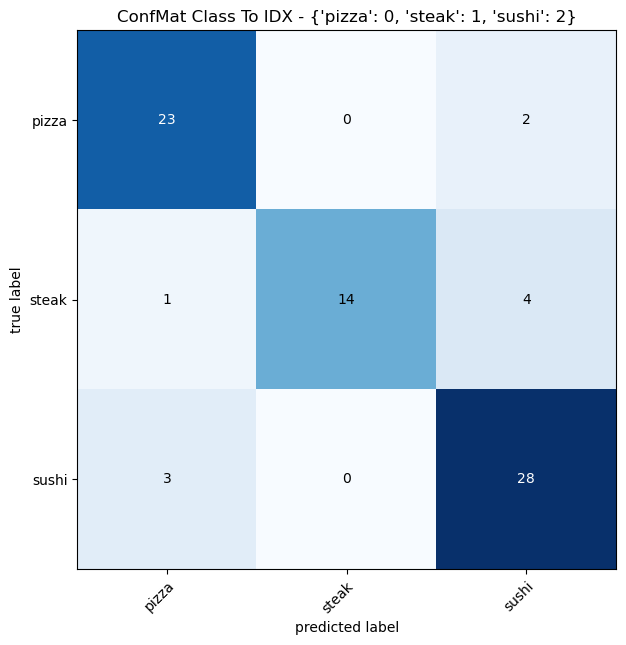

In [10]:
engine.plot_confusion_matrix_model(model, dataloader, device)

In [12]:
a,b = torch.cuda.mem_get_info()
round(a*1e-9,3), round(b*1e-9,3)

(15.247, 17.179)

In [13]:
!nvidia-smi

Sun Mar 16 20:23:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   67C    P8             27W /  150W |    1380MiB /  16384MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----